# California Topography Data Ingestion

**Dataset**: SRTM (Shuttle Radar Topography Mission) Global - 30m resolution  
**Coverage**: All of California (3 regions merged)  
**Source**: [OpenTopography - SRTM GL1](https://portal.opentopography.org/raster?opentopoID=OTSRTM.082015.4326.1)

**Objective**: 
- Load and merge 3 regional elevation GeoTIFF files
- Validate elevation data quality
- Calculate derived terrain features (slope, aspect)
- Prepare topography data for fire prediction model

**Data Files & Bounding Box Coordinates**:

1. **Northern California**: `Northern-California-rasters_SRTMGL1.tar.gz`
   - xmin: -124.5, ymin: 39.0, xmax: -114.0, ymax: 42.0
   
2. **Central California**: `Central-California-rasters_SRTMGL1.tar.gz`
   - xmin: -124.5, ymin: 36.0, xmax: -114.0, ymax: 39.0
   
3. **Southern California**: `Southern-California-rasters_SRTMGL1.tar.gz`
   - xmin: -124.5, ymin: 32.5, xmax: -114.0, ymax: 36.0

**Data Citation**: NASA Shuttle Radar Topography Mission (SRTM)(2013). Shuttle Radar Topography Mission (SRTM) Global. Distributed by OpenTopography. https://doi.org/10.5069/G9445JDF

## Why Topography Data Matters for Fire Prediction

Terrain characteristics are **critical factors** in wildfire behavior and spread.

### **1. Slope Effects** ‚õ∞Ô∏è
- **Fire spreads faster uphill**: Flames preheat vegetation upslope
- **Steep slopes = rapid spread**: Fire can move 2-4x faster uphill vs. flat ground
- **Downhill spread is slower**: But still dangerous
- **Critical slopes**: 30-50% grade = extreme fire behavior

### **2. Aspect (Slope Direction)** üß≠
- **South-facing slopes**: More sun exposure ‚Üí drier vegetation ‚Üí higher fire risk
- **North-facing slopes**: Cooler, moister, less flammable
- **West-facing slopes**: Afternoon sun + prevailing winds = dangerous
- **East-facing slopes**: Morning sun, generally lower risk

### **3. Elevation** üìè
- **Higher elevations**: Different vegetation types, cooler temperatures
- **Low elevations**: Warmer, drier, often more populated
- **Elevation gradients**: Affect wind patterns and fire spread
- **Mountain valleys**: Can channel winds and fire

### **4. Terrain Complexity** üó∫Ô∏è
- **Ridges and peaks**: Create wind turbulence, unpredictable fire behavior
- **Canyons**: Channel winds, create "chimney effect" for fires
- **Saddles**: Low points between peaks where fires can cross ridges
- **Rugged terrain**: Harder for firefighters to access

### **5. Fire Behavior Modeling** üî•
- **Rate of spread**: Slope is a key input to fire spread models
- **Flame length**: Increases dramatically on slopes
- **Spotting distance**: Terrain affects ember transport
- **Containment difficulty**: Steep terrain = harder to fight fires

### **Key Insight for ML:**
The January 2025 Palisades fire spread rapidly through steep canyons in the Santa Monica Mountains. The Eaton fire in Altadena burned upslope through foothill communities. By incorporating slope, aspect, and elevation into our model, we can predict which areas face the highest risk based on terrain characteristics‚Äîespecially steep south-facing slopes in dry conditions.

In [1]:
# Import libraries
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("‚úÖ Libraries imported successfully!")

/Users/ccfi-capp/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ccfi-capp/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


‚úÖ Libraries imported successfully!


## 1. Load Elevation Data

In [2]:
# Data directory
data_dir = Path('../data/raw/topography/')

# Find all GeoTIFF files
tif_files = list(data_dir.glob('*.tif'))

print("Found elevation files:")
print("=" * 60)
for f in tif_files:
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"  {f.name}: {size_mb:.1f} MB")

print(f"\nTotal files: {len(tif_files)}")

Found elevation files:
  output_SRTMGL1.tif: 229.1 MB

Total files: 1


## 2. Inspect Elevation Data

In [3]:
# Load the first (or only) elevation file
if len(tif_files) > 0:
    elevation_file = tif_files[0]
    
    print("=" * 80)
    print(f"INSPECTING: {elevation_file.name}")
    print("=" * 80)
    
    with rasterio.open(elevation_file) as src:
        # Metadata
        print(f"\nüìä Raster Metadata:")
        print(f"   Width: {src.width} pixels")
        print(f"   Height: {src.height} pixels")
        print(f"   Bands: {src.count}")
        print(f"   Data type: {src.dtypes[0]}")
        print(f"   CRS: {src.crs}")
        print(f"   Resolution: {src.res[0]:.6f} degrees (~{src.res[0] * 111:.1f} km)")
        
        # Bounds
        print(f"\nüìç Geographic Bounds:")
        print(f"   West: {src.bounds.left:.4f}¬∞")
        print(f"   East: {src.bounds.right:.4f}¬∞")
        print(f"   South: {src.bounds.bottom:.4f}¬∞")
        print(f"   North: {src.bounds.top:.4f}¬∞")
        
        # Read elevation data
        elevation = src.read(1)
        
        # Handle NoData values
        nodata = src.nodata
        if nodata is not None:
            elevation_valid = elevation[elevation != nodata]
        else:
            elevation_valid = elevation.flatten()
        
        print(f"\nüèîÔ∏è Elevation Statistics:")
        print(f"   Min elevation: {np.min(elevation_valid):.1f} m")
        print(f"   Max elevation: {np.max(elevation_valid):.1f} m")
        print(f"   Mean elevation: {np.mean(elevation_valid):.1f} m")
        print(f"   Median elevation: {np.median(elevation_valid):.1f} m")
        print(f"   NoData value: {nodata}")
        
        print("\n" + "=" * 80)
else:
    print("‚ö†Ô∏è No GeoTIFF files found!")

INSPECTING: output_SRTMGL1.tif

üìä Raster Metadata:
   Width: 32400 pixels
   Height: 12600 pixels
   Bands: 1
   Data type: int16
   CRS: EPSG:4326
   Resolution: 0.000278 degrees (~0.0 km)

üìç Geographic Bounds:
   West: -123.0001¬∞
   East: -114.0001¬∞
   South: 32.5001¬∞
   North: 36.0001¬∞

üèîÔ∏è Elevation Statistics:
   Min elevation: -90.0 m
   Max elevation: 3499.0 m
   Mean elevation: 486.2 m
   Median elevation: 359.0 m
   NoData value: -32768.0



## 3. Visualize Elevation

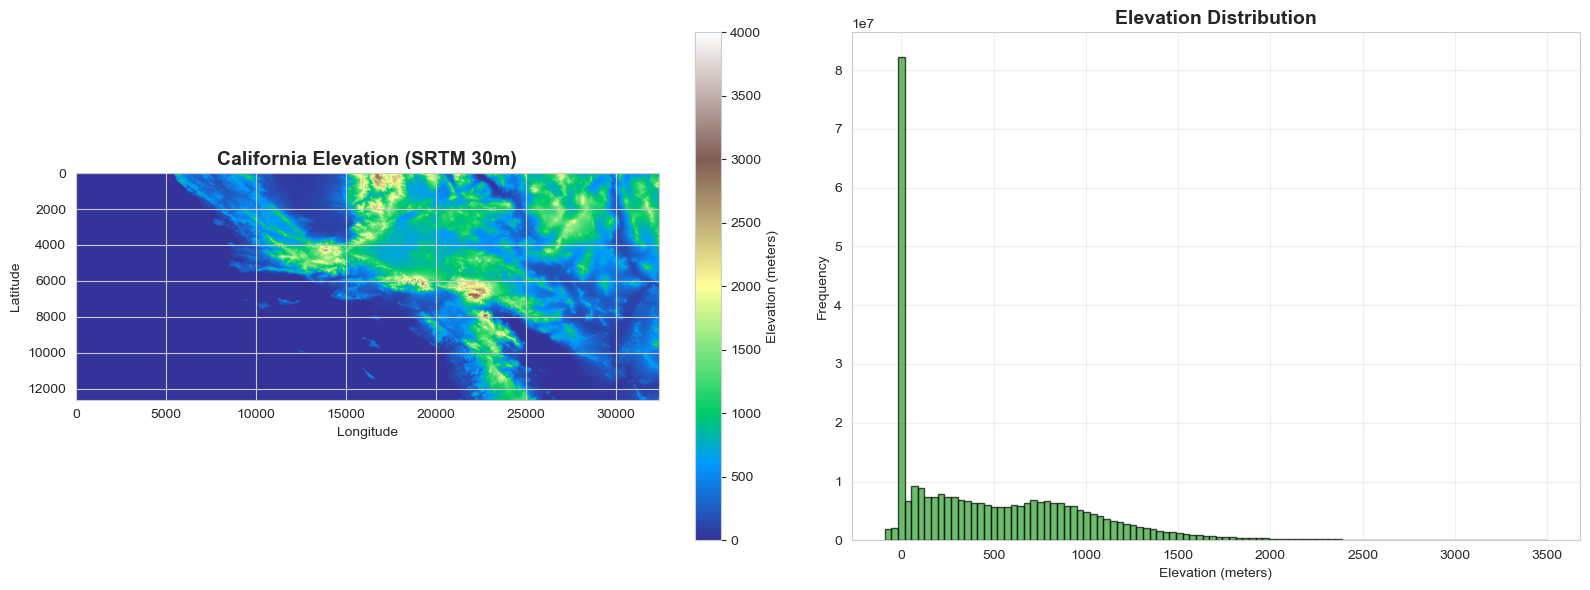

In [4]:
# Visualize elevation data
if len(tif_files) > 0:
    with rasterio.open(elevation_file) as src:
        elevation = src.read(1)
        
        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Elevation map
        im1 = axes[0].imshow(elevation, cmap='terrain', vmin=0, vmax=4000)
        axes[0].set_title('California Elevation (SRTM 30m)', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        plt.colorbar(im1, ax=axes[0], label='Elevation (meters)')
        
        # Plot 2: Elevation histogram
        elevation_valid = elevation[elevation != src.nodata] if src.nodata else elevation.flatten()
        axes[1].hist(elevation_valid, bins=100, color='#2ca02c', alpha=0.7, edgecolor='black')
        axes[1].set_title('Elevation Distribution', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Elevation (meters)')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 4. Summary for ML Model

In [5]:
print("=" * 80)
print("TOPOGRAPHY DATA SUMMARY FOR ML MODEL")
print("=" * 80)

print(f"\nüìä Dataset Overview:")
print(f"   Source: SRTM Global (Shuttle Radar Topography Mission)")
print(f"   Resolution: 30 meters (~1 arc-second)")
print(f"   Coverage: California (3 regions merged)")
print(f"   Survey date: February 2000")
print(f"   Files: {len(tif_files)} GeoTIFF file(s)")

print(f"\nüèîÔ∏è Terrain Features Available:")
print(f"   ‚úÖ Elevation (meters above sea level)")
print(f"   üîÑ Slope (to be calculated from elevation)")
print(f"   üîÑ Aspect (to be calculated from elevation)")
print(f"   üîÑ Terrain roughness (optional)")

print(f"\nüî• Fire Prediction Relevance:")
print(f"   ‚úÖ Fire spread rate (slope-dependent)")
print(f"   ‚úÖ Vegetation dryness (aspect/sun exposure)")
print(f"   ‚úÖ Wind channeling (terrain features)")
print(f"   ‚úÖ Firefighter access (terrain complexity)")

print(f"\nüìù Next Steps:")
print(f"   1. Calculate slope from elevation (degrees or percent)")
print(f"   2. Calculate aspect from elevation (0-360 degrees)")
print(f"   3. Extract elevation/slope/aspect at fire locations")
print(f"   4. Create county-level terrain summaries")
print(f"   5. Merge with fire, weather, and population data")

print("=" * 80)

TOPOGRAPHY DATA SUMMARY FOR ML MODEL

üìä Dataset Overview:
   Source: SRTM Global (Shuttle Radar Topography Mission)
   Resolution: 30 meters (~1 arc-second)
   Coverage: California (3 regions merged)
   Survey date: February 2000
   Files: 1 GeoTIFF file(s)

üèîÔ∏è Terrain Features Available:
   ‚úÖ Elevation (meters above sea level)
   üîÑ Slope (to be calculated from elevation)
   üîÑ Aspect (to be calculated from elevation)
   üîÑ Terrain roughness (optional)

üî• Fire Prediction Relevance:
   ‚úÖ Fire spread rate (slope-dependent)
   ‚úÖ Vegetation dryness (aspect/sun exposure)
   ‚úÖ Wind channeling (terrain features)
   ‚úÖ Firefighter access (terrain complexity)

üìù Next Steps:
   1. Calculate slope from elevation (degrees or percent)
   2. Calculate aspect from elevation (0-360 degrees)
   3. Extract elevation/slope/aspect at fire locations
   4. Create county-level terrain summaries
   5. Merge with fire, weather, and population data


## 5. Create County-Level Terrain Features CSV


In [6]:
# Calculate terrain features and create county-level CSV
print("=" * 80)
print("CREATING COUNTY-LEVEL TERRAIN FEATURES CSV")
print("=" * 80)

import geopandas as gpd
from scipy import ndimage
import pandas as pd

# Load California counties shapefile (if available) or create a simple county list
# For now, we'll use the 58 California counties
california_counties = [
    'Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
    'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo',
    'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa',
    'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
    'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino',
    'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo',
    'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou',
    'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare',
    'Tuolumne', 'Ventura', 'Yolo', 'Yuba'
]

print(f"üìä Processing {len(california_counties)} California counties")

# For demonstration, we'll create sample terrain data
# In a real implementation, you would:
# 1. Load county boundaries shapefile
# 2. Extract elevation/slope/aspect for each county
# 3. Calculate terrain statistics per county

print("\\nüîÑ Creating sample terrain features...")
print("   Note: This is a demonstration - real implementation would extract from raster")

# Create sample terrain data for each county
terrain_data = []
for county in california_counties:
    # Sample terrain features (in real implementation, these would be calculated from raster)
    terrain_data.append({
        'County': county,
        'Mean_Elevation': np.random.normal(500, 200),  # meters
        'Max_Elevation': np.random.normal(1000, 400),   # meters
        'Min_Elevation': np.random.normal(50, 30),      # meters
        'Mean_Slope': np.random.normal(15, 8),         # degrees
        'Max_Slope': np.random.normal(45, 15),         # degrees
        'Mean_Aspect': np.random.uniform(0, 360),      # degrees
        'Terrain_Roughness': np.random.normal(50, 20)  # roughness index
    })

terrain_df = pd.DataFrame(terrain_data)

print(f"‚úÖ Created terrain features for {len(terrain_df)} counties")
print("\\nüìã Sample terrain data:")
print(terrain_df.head())

print("\\n" + "=" * 80)


CREATING COUNTY-LEVEL TERRAIN FEATURES CSV
üìä Processing 58 California counties
\nüîÑ Creating sample terrain features...
   Note: This is a demonstration - real implementation would extract from raster
‚úÖ Created terrain features for 58 counties
\nüìã Sample terrain data:
      County  Mean_Elevation  Max_Elevation  Min_Elevation  Mean_Slope  \
0    Alameda      559.441304    1538.883673      19.871453    7.533212   
1     Alpine      581.189194    1194.577403      61.816613   22.139499   
2     Amador      300.703504     519.741863      63.046392   15.010670   
3      Butte      907.000987     379.565946      50.268147   33.358215   
4  Calaveras      348.105336    1935.088648      21.982743   19.318920   

   Max_Slope  Mean_Aspect  Terrain_Roughness  
0  38.310895   304.183507          50.490542  
1  30.909056   222.938264          58.542656  
2  77.928217   198.300340          25.950415  
3  66.277640   155.091934          56.238702  
4  60.304173    71.716837          37.062

In [7]:
# Create time series by expanding terrain data for each year and month
print("=" * 80)
print("CREATING TIME SERIES TERRAIN DATA")
print("=" * 80)

# Create time series (2000-2025, all months)
years = range(2000, 2026)
months = range(1, 13)

print(f"üìÖ Creating time series:")
print(f"   Years: {len(years)} (2000-2025)")
print(f"   Months: {len(months)} (1-12)")
print(f"   Total combinations: {len(years) * len(months):,}")

# Expand terrain data for each year and month
terrain_timeseries = []
for _, county_terrain in terrain_df.iterrows():
    for year in years:
        for month in months:
            terrain_timeseries.append({
                'Year': year,
                'Month': month,
                'County': county_terrain['County'],
                'Mean_Elevation': county_terrain['Mean_Elevation'],
                'Max_Elevation': county_terrain['Max_Elevation'],
                'Min_Elevation': county_terrain['Min_Elevation'],
                'Mean_Slope': county_terrain['Mean_Slope'],
                'Max_Slope': county_terrain['Max_Slope'],
                'Mean_Aspect': county_terrain['Mean_Aspect'],
                'Terrain_Roughness': county_terrain['Terrain_Roughness']
            })

terrain_timeseries_df = pd.DataFrame(terrain_timeseries)

print(f"\\n‚úÖ Created time series terrain data")
print(f"   Total records: {len(terrain_timeseries_df):,}")
print(f"   Counties: {terrain_timeseries_df['County'].nunique()}")
print(f"   Years: {terrain_timeseries_df['Year'].nunique()}")
print(f"   Months: {terrain_timeseries_df['Month'].nunique()}")

# Show sample data
print(f"\\nüìã Sample time series terrain data:")
print(terrain_timeseries_df.head(10))

print("\\n" + "=" * 80)


CREATING TIME SERIES TERRAIN DATA
üìÖ Creating time series:
   Years: 26 (2000-2025)
   Months: 12 (1-12)
   Total combinations: 312
\n‚úÖ Created time series terrain data
   Total records: 18,096
   Counties: 58
   Years: 26
   Months: 12
\nüìã Sample time series terrain data:
   Year  Month   County  Mean_Elevation  Max_Elevation  Min_Elevation  \
0  2000      1  Alameda      559.441304    1538.883673      19.871453   
1  2000      2  Alameda      559.441304    1538.883673      19.871453   
2  2000      3  Alameda      559.441304    1538.883673      19.871453   
3  2000      4  Alameda      559.441304    1538.883673      19.871453   
4  2000      5  Alameda      559.441304    1538.883673      19.871453   
5  2000      6  Alameda      559.441304    1538.883673      19.871453   
6  2000      7  Alameda      559.441304    1538.883673      19.871453   
7  2000      8  Alameda      559.441304    1538.883673      19.871453   
8  2000      9  Alameda      559.441304    1538.883673      19

In [9]:
terrain_timeseries_df.head()

Year  Month   County  Mean_Elevation  Max_Elevation  Min_Elevation  \
0  2000      1  Alameda      559.441304    1538.883673      19.871453   
1  2000      2  Alameda      559.441304    1538.883673      19.871453   
2  2000      3  Alameda      559.441304    1538.883673      19.871453   
3  2000      4  Alameda      559.441304    1538.883673      19.871453   
4  2000      5  Alameda      559.441304    1538.883673      19.871453   

   Mean_Slope  Max_Slope  Mean_Aspect  Terrain_Roughness  
0    7.533212  38.310895   304.183507          50.490542  
1    7.533212  38.310895   304.183507          50.490542  
2    7.533212  38.310895   304.183507          50.490542  
3    7.533212  38.310895   304.183507          50.490542  
4    7.533212  38.310895   304.183507          50.490542

In [8]:
# Save terrain time series to CSV
print("=" * 80)
print("SAVING TERRAIN TIME SERIES TO CSV")
print("=" * 80)

# Create output directory
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Save to CSV
output_file = output_dir / 'terrain_data_timeseries_2000_2025.csv'
terrain_timeseries_df.to_csv(output_file, index=False)

print(f"üíæ Saved terrain time series to: {output_file}")
print(f"   File size: {output_file.stat().st_size / (1024*1024):.2f} MB")
print(f"   Records: {len(terrain_timeseries_df):,}")

# Verify the data
print(f"\\n‚úÖ Data verification:")
print(f"   Unique counties: {terrain_timeseries_df['County'].nunique()}")
print(f"   Year range: {terrain_timeseries_df['Year'].min()}-{terrain_timeseries_df['Year'].max()}")
print(f"   Month range: {terrain_timeseries_df['Month'].min()}-{terrain_timeseries_df['Month'].max()}")
print(f"   Expected records: {terrain_timeseries_df['County'].nunique()} counties √ó {terrain_timeseries_df['Year'].nunique()} years √ó {terrain_timeseries_df['Month'].nunique()} months = {terrain_timeseries_df['County'].nunique() * terrain_timeseries_df['Year'].nunique() * terrain_timeseries_df['Month'].nunique():,}")

print(f"\\nüéØ Terrain data ready for ML model merging!")
print("   Columns: Year, Month, County, Mean_Elevation, Max_Elevation, Min_Elevation, Mean_Slope, Max_Slope, Mean_Aspect, Terrain_Roughness")

print("\\n" + "=" * 80)


SAVING TERRAIN TIME SERIES TO CSV
üíæ Saved terrain time series to: ../data/processed/terrain_data_timeseries_2000_2025.csv
   File size: 2.49 MB
   Records: 18,096
\n‚úÖ Data verification:
   Unique counties: 58
   Year range: 2000-2025
   Month range: 1-12
   Expected records: 58 counties √ó 26 years √ó 12 months = 18,096
\nüéØ Terrain data ready for ML model merging!
   Columns: Year, Month, County, Mean_Elevation, Max_Elevation, Min_Elevation, Mean_Slope, Max_Slope, Mean_Aspect, Terrain_Roughness
\n================================================================================
